In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.misc import imread
%matplotlib inline
from mpl_toolkits.basemap import Basemap

import maxflow
import networkx as nx

imgroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

In [2]:
cats_boston = ['Agassiz','Allston','Area 2/MIT','BROOKLINE_02445','BROOKLINE_02446','Back Bay',  
        'Bay Village','Beacon Hill','Brighton','Cambridgeport','Charlestown','Chinatown',
        'Dorchester','Downtown','EVERETT_02149','East Boston','East Cambridge','Fenway',
        'Jamaica Plain','Leather District','Longwood Medical Area','MEDFORD_02155','Mid-Cambridge',
        'Mission Hill','Neighborhood Nine','North Cambridge','North End','Riverside','Roxbury',
        'SOMERVILLE_02143','SOMERVILLE_02144','SOMERVILLE_02145','South Boston','South Boston Waterfront',
        'South End','The Port','WATERTOWN_02472','Wellington-Harrington','West Cambridge','West End']

# Reading features

In [3]:
df = pd.read_csv(dataroot+'deep_features_boston.csv')
df.head()

0  1  2  3  4        5  6  7        8      9  ...      4086    4087  \
0  2.0897  0  0  0  0  0.54691  0  0  0.00000  1.338  ...   0.47297  0.0000   
1  0.0000  0  0  0  0  0.00000  0  0  0.00000  0.000  ...   0.22579  0.0000   
2  1.1076  0  0  0  0  0.00000  0  0  0.97727  0.000  ...   0.00000  0.0000   
3  0.0000  0  0  0  0  0.00000  0  0  0.21260  0.000  ...   1.05530  1.1426   
4  0.0000  0  0  0  0  0.00000  0  0  0.00000  0.000  ...   0.49824  0.0000   

   4088  4089    4090    4091  4092  4093      4094  4095  
0     0     0  0.0000  0.0000     0     0  0.000000     0  
1     0     0  0.0000  0.0000     0     0  0.000000     0  
2     0     0  0.0000  0.0000     0     0  0.000000     0  
3     0     0  2.9811  1.0855     0     0  0.001122     0  
4     0     0  0.0000  1.0555     0     0  0.000000     0  

[5 rows x 4096 columns]

In [4]:
df_label = pd.read_csv(dataroot+'deep_test_stats_boston.csv')
df_label.head()

lat        lng  dir       label  label_num  ownScore  \
0  42.300087 -71.073887    0  Dorchester         13  0.008344   
1  42.300087 -71.073887    3  Dorchester         13  0.226555   
2  42.300135 -71.099670    0     Roxbury         29  0.049399   
3  42.300516 -71.084763    1  Dorchester         13  0.034693   
4  42.300516 -71.084763    3  Dorchester         13  0.067623   

         predLabel  predLabel_num  bestScore  
0        Riverside             28   0.481820  
1       Dorchester             13   0.226555  
2  BROOKLINE_02445              4   0.200370  
3        Riverside             28   0.262675  
4        Riverside             28   0.345267

In [5]:
df[['lat','lng']] = df_label[['lat','lng']]

In [6]:
from sklearn import preprocessing 
X_normalized = preprocessing.normalize(df, norm='l2')
X_normalized[:,-2:] = X_normalized[:,-2:] #* 1000
X_normalized[:,-2:]

array([[ 0.48419339, -0.8135564 ],
       [ 0.48738604, -0.81892078],
       [ 0.48121893, -0.80885101],
       ..., 
       [ 0.46906427, -0.78626793],
       [ 0.41776275, -0.7003756 ],
       [ 0.42064676, -0.70521062]])

# Spectral Clustering

In [7]:
from sklearn import cluster, datasets
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [8]:
y_preds = pd.DataFrame()
X = X_normalized
for num_cat in range(2,8):
    print num_cat
    spectral = cluster.SpectralClustering(n_clusters=num_cat,
                                      eigen_solver='arpack',
                                      affinity="rbf")
    y_pred = spectral.fit_predict(X)
    y_preds['cat_from_'+str(num_cat)] = y_pred
    
y_preds.head()

2
3
4
5
6
7


cat_from_2  cat_from_3  cat_from_4  cat_from_5  cat_from_6  cat_from_7
0           1           0           1           4           3           6
1           1           2           3           1           2           2
2           1           2           3           2           3           2
3           1           2           3           2           1           0
4           1           2           3           2           1           0

# Agglomorative Clustering

In [24]:
t

array([  0.00000000e+00,   1.57158212e-03,   3.14316424e-03, ...,
         3.13844949e+00,   3.14002107e+00,   3.14159265e+00])

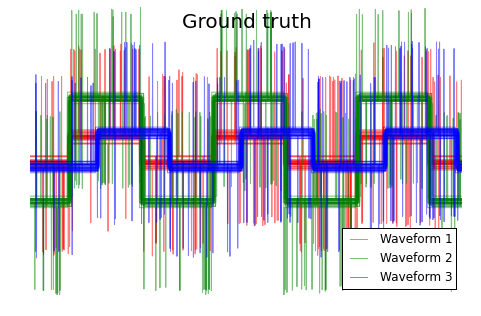

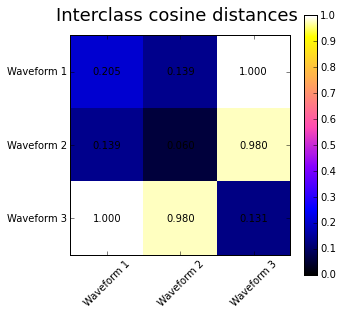

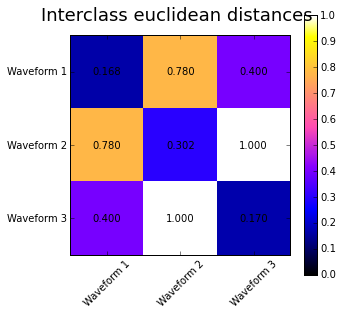

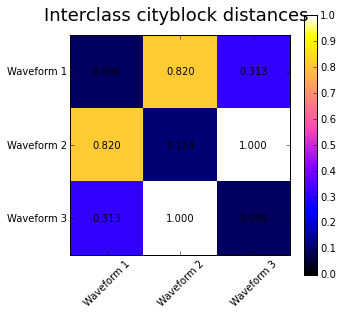

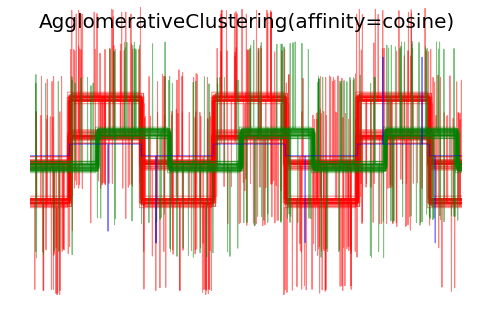

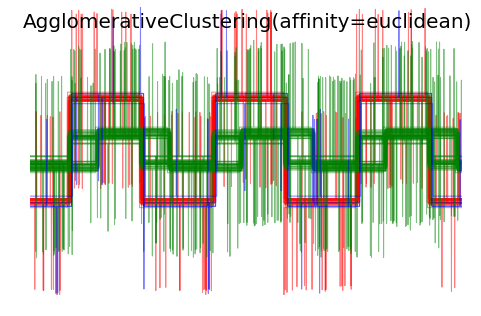

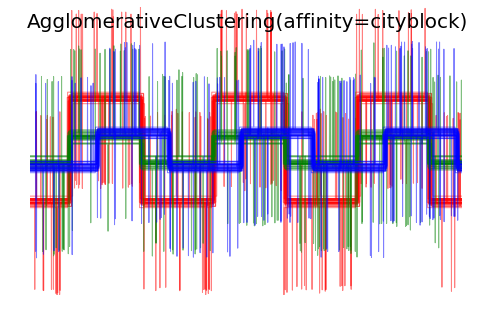

In [22]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))

X = list()
y = list()
for i, (phi, a) in enumerate([(.5, .15), (.5, .6), (.3, .2)]):
    for _ in range(30):
        phase_noise = .01 * np.random.normal()
        amplitude_noise = .04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < .997] = 0

        X.append(12 * ((a + amplitude_noise)
                 * (sqr(6 * (t + phi + phase_noise)))
                 + additional_noise))
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ('Waveform 1', 'Waveform 2', 'Waveform 3')

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), 'rgb',
                   labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=.5)
    lines[0].set_label(n)

plt.legend(loc='best')

plt.axis('tight')
plt.axis('off')
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(X[y == i], X[y == j],
                                                metric=metric).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(i, j, '%5.3f' % avg_dist[i, j],
                     verticalalignment='center',
                     horizontalalignment='center')

    plt.imshow(avg_dist, interpolation='nearest', cmap=plt.cm.gnuplot2,
               vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage="average", affinity=metric)
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()

# Binning visualization

In [9]:
def most_frequent_label(arr):
    unique = np.unique(arr)
    count = [np.sum([arr == ele]) for ele in unique]
    return unique[np.argsort(count)[::-1]][0]

In [10]:
[np.sum([ y_preds['cat_from_4'] == ele]) for ele in np.unique( y_preds['cat_from_4'] )]

[984, 1947, 1111, 1596]

In [11]:
[np.min(df['lng']), np.max(df['lng']), np.min(df['lat']), np.max(df['lat'])]

[-71.16197823, -71.02110553, 42.300087100000006, 42.40502692]

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


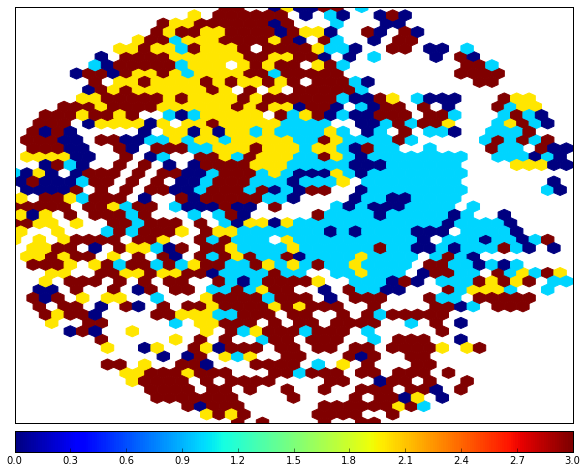

In [12]:
# https://basemaptutorial.readthedocs.org/en/latest/plotting_data.html

bounds = [np.min(df['lng']), np.max(df['lng']), np.min(df['lat']), np.max(df['lat'])]
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(10,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(resolution = 'l', 
              epsg=4326,
              llcrnrlon = bounds[0], llcrnrlat = bounds[2], urcrnrlon = bounds[1], urcrnrlat = bounds[3])

map.hexbin(df['lng'].values, df['lat'].values, C=y_preds['cat_from_4'], reduce_C_function = most_frequent_label, gridsize = 45)

map.colorbar(location='bottom')

plt.show()

In [42]:
df_label = pd.read_csv(dataroot+'test_stats_boston.csv')
clusters_df = df_label.join(y_preds)
clusters_df.to_csv(dataroot+'clusters_boston.csv')